In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from skimage.metrics import structural_similarity as SSIM
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from WGAIN_model import *
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

2.0.0
Num GPUs Available:  0


In [8]:
def decode_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img
def prepare_noise_eval_dataset(ds, batch_size, side, throw_ratio):
    def introduce_missingness(X):
        # per row ratios how much should be thrown (each row a different number, max is max_ratio_to_throw)
        ratio_to_throw = throw_ratio*tf.ones([X.shape[0], side, side, 1])
        # binary mask of which features are left (0 - missing, 1 - OK)
        mask = tf.dtypes.cast(tf.math.greater(tf.random.uniform([X.shape[0], side, side, 1]), ratio_to_throw), tf.float32)
        # Do the mask to have 3 channels
        mask3 = tf.repeat(mask, [3], axis = 3)
        # prepare randomness
        randZ = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ = tf.math.multiply(1 - mask3, randZ)
        # apply the mask - leave original and substitute randoms for missings
        newX = tf.math.multiply(mask3, X)
        # return a training pair
        return (X, newX, mask, randZ)
    # do the preparation
    ds = ds.map(decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size,drop_remainder = True)
    ds = ds.map(introduce_missingness, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds
def prepare_singlesquare_eval_dataset(ds, batch_size, side):
    def introduce_missingness(X):
        # centered square
        sides = np.ones(shape=(X.shape[0],))*int(side/2.0)
        corner_l = int(side / 2.0) -  (sides/2.0).astype(int)
        corner_u = int(side / 2.0) +  (sides/2.0).astype(int)
        center_mask = np.ones((X.shape[0], side, side, 1)).astype('float32')
        for i in range(X.shape[0]):
            center_mask[i,corner_l[i]:corner_u[i],corner_l[i]:corner_u[i],:] = 0
        # binary mask of which features are left (0 - missing, 1 - OK)
        mask = tf.constant(center_mask, dtype=tf.float32)
        # Do the mask to have 3 channels
        mask3 = tf.repeat(mask, [3], axis = 3)
        # prepare randomness
        randZ = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ = tf.math.multiply(1 - mask3, randZ)
        # apply the mask - leave original and substitute randoms for missings
        newX = tf.math.multiply(mask3, X)
        # return a training pair
        return (X, newX, mask, randZ)
    # do the preparation
    ds = ds.map(decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size,drop_remainder = True)
    ds = ds.map(introduce_missingness, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

def prepare_multisquare_eval_dataset(ds, batch_size, side):
    def introduce_missingness(X):
        # multi square
        DAMAGE = 0.3
        SQUARES = 5.0
        image_area = side*side
        damage_area = DAMAGE*image_area
        one_square_area = damage_area / SQUARES
        one_square_side = int(np.sqrt(one_square_area))
        test_mask = np.ones((X.shape[0],side,side,1))
        for i in range(test_mask.shape[0]):
            for k in range(int(SQUARES)):
                x = np.random.randint(side - one_square_side)
                y = np.random.randint(side - one_square_side)
                test_mask[i,x:x+one_square_side,y:y+one_square_side,0] = 0
        # binary mask of which features are left (0 - missing, 1 - OK)
        mask = tf.constant(test_mask, dtype=tf.float32)
        # Do the mask to have 3 channels
        mask3 = tf.repeat(mask, [3], axis = 3)
        # prepare randomness
        randZ = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ = tf.math.multiply(1 - mask3, randZ)
        # apply the mask - leave original and substitute randoms for missings
        newX = tf.math.multiply(mask3, X)
        # return a training pair
        return (X, newX, mask, randZ)
    # do the preparation
    ds = ds.map(decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size,drop_remainder = True)
    ds = ds.map(introduce_missingness, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

def evaluate_dataset(dataset, batch_size, side, print_log = True, max_batch = 5):
    count = 0
    psnr = 0
    ssim = 0
    for i, (origX, newX, mask, randZ) in enumerate(dataset):
        if max_batch and i > max_batch:
            break
        if print_log:
            print(i)
        imputed = generator([newX, mask, randZ])
        imputed = mask*origX + (1-mask)*imputed
        count += imputed.shape[0]
        for j in range(imputed.shape[0]):
            ssim += SSIM(origX[j,:,:,:].numpy(), imputed[j,:,:,:].numpy(), multichannel=True)
            psnr += cv2.PSNR(origX[j,:,:,:].numpy(), imputed[j,:,:,:].numpy(), 1)
        if print_log:
            print("sample count:", count)
            print("avg test PSNR: ", psnr/count)
            print("avg test SSIM: ", ssim/count)
    return count, psnr/count, ssim/count

In [30]:
batch_size = 128
side = 128

path = "./datasets/paris/paris128_%s"
paris_test = data.Dataset.list_files(path%'test' + str('/*.jpg'))
paris_test_d = prepare_multisquare_eval_dataset(paris_test, batch_size, side)

# create the model
generator = build_generator(side)
# generator.summary()
critic = build_critic(side)
# critic.summary()

# Load weights
model_path = "saved_models_paris/"

generator.load_weights(model_path + "gultimate_final")
critic.load_weights(model_path + "cultimate_final")

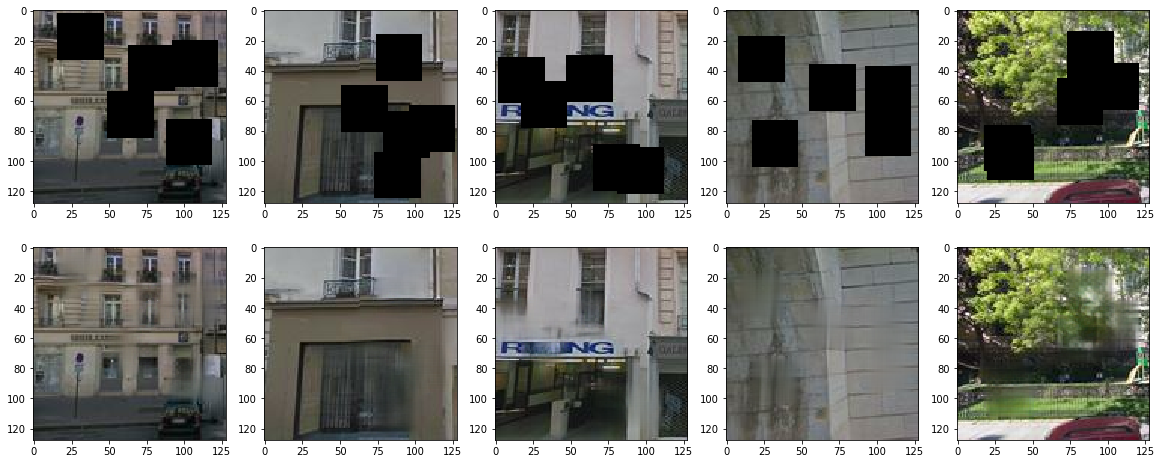

In [31]:
it = iter(paris_test_d)
origX, newX, mask, randZ = next(it)
g_out = generator([newX, mask, randZ])
plt.figure(figsize=(20,8))
for i in range(min(5, batch_size)):
    plt.subplot(2,5,i+1)
    plt.imshow(newX[i,:,:,:])
    plt.subplot(2,5,i+6)
    plt.imshow(g_out[i,:,:,:])
plt.show()

In [32]:
counts = []
psnrs = []
ssims = []
scenarios = ['center', 'multi', 'noise 50', 'noise 75', 'noise 95']
datasets = [
    prepare_singlesquare_eval_dataset(paris_test, batch_size, side),
    prepare_multisquare_eval_dataset(paris_test, batch_size, side),
    prepare_noise_eval_dataset(paris_test, batch_size, side, 0.50),
    prepare_noise_eval_dataset(paris_test, batch_size, side, 0.75),
    prepare_noise_eval_dataset(paris_test, batch_size, side, 0.95),
]
for i in range(len(datasets)):
    print(scenarios[i])
    _count, _psnr, _ssim = evaluate_dataset(datasets[i], batch_size, side, False, max_batch=1000)
    print(_count, _psnr, _ssim)
    counts.append(_count)
    psnrs.append(_psnr)
    ssims.append(_ssim)

center
4352 25.00440404702223 0.8786478064368285
multi
4352 26.506256389529 0.9038087755203937
noise 50
4352 31.48230232011616 0.9576998811011656
noise 75
4352 27.732484161006678 0.9033249806062014
noise 95
4352 22.721294336196582 0.7400132199096681
